<div style="background-image:url('../share/images/header.svg'); padding: 0px; background-size:cover; background-opacity:50%; border-radius:5px; height: 250px">
    <div style="float:right; margin: 50px; padding: 20px; background:rgba(255,255,255,0.7); width: 50%; height: 150px">
        <div style="position:relative; top:50%; transform: translateY(-50%)">
            <div style="font-size: xx-large; font-weight:900; color:rgba(0,0,0,0.8); line-height:100%">Rotational Seismology</div>
            <div style="font-size: large; padding-top: 20px; color:rgba(0,0,0,0.5)">Data Download + Pre-Processing</div>
        </div>
    </div>
</div>

Seismo-Live: http://seismo-live.org

##### Authors:
* Johannes Salvermoser ([@salve-](https://github.com/salve-))

---

<h1>Rotational Seismology Tutorial: Data Download + Pre-Processing </h1>
<h4><ul> <li>How do I download ring laser data?</li><br>
<li>What pre-processing do I need to perform?</li><br>
<li>... and how can I do this using Obspy?</li></h4>

![](images/obspy_logo_full_524x179px.png)

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

### Pick events from catalog to define start- and endtimes of traces
The first step to compare waveform data of a ring laser and a collocated seismometer is to choose which time period we want to look at. <br>
Usually, we want to observe Love waves generated by earthquake events, so we need to pick an event from a earthquake catalog <br>
which is done using the <a href=http://www.fdsn.org/>FDSN client</a>. <br>
<br>
The FDSN client fetches an event catalog from a data center - in this case IRIS - which can be filtered by different criteria, such as: 
<ul><li>magnitude</li> <li>longitude & latitude</li> <li>depth</li> <li>starttime & endtime</li> <li>catalog</li></ul>

The catalog we use here is the <a href=http://www.globalcmt.org/> Global CMT catalog</a> which contains moment magnitude picked events.

In [2]:
from obspy.clients.fdsn import Client as fdsnClient
from obspy.core import UTCDateTime

c_fdsn = fdsnClient('IRIS')
cat = c_fdsn.get_events(minmagnitude=9.0, starttime=UTCDateTime(2011,1,1), endtime=UTCDateTime(2012,1,1))
event = cat[0]
print(cat)
start = event.origins[0].time
end = start + 3600

1 Event(s) in Catalog:
2011-03-11T05:46:23.200000Z | +38.296, +142.498 | 9.1 MW


### Download waveform traces
Once we selected an event and obtained the earthquake's origin time, we can download the waveform data using the Arclink client, which is a distributed data request protocol that can be used to access archived waveform data (for more information see <a href=http://docs.obspy.org/archive/0.10.2/packages/obspy.arclink.html> Obspy's Arclink documentation</a>)<br>
<br>
For each requested waveform component we need to specify its unique identifier, consisting of:
<ul><li>network</li> <li>station</li> <li>location</li> <li>channel</li> <li>starttime & endtime</li> </ul>
<br>
In order to simplify the subsequent handling, we unite the three seismometer components [N,E,Z] (= traces) to a single **stream object**. 

In [3]:
from obspy.core.stream import Stream

c_rot = fdsnClient('http://erde.geophysik.uni-muenchen.de')  # rotational data source
c_bb  = fdsnClient('BGR')  # broadband data source

RLAS = c_rot.get_waveforms(network='BW', station='RLAS', location='', channel='BJZ', starttime=start, endtime=end)
BHE = c_bb.get_waveforms(network='GR', station='WET', location='', channel='BHE', starttime=start, endtime=end)
BHN = c_bb.get_waveforms(network='GR', station='WET', location='', channel='BHN', starttime=start, endtime=end)
BHZ = c_bb.get_waveforms(network='GR', station='WET', location='', channel='BHZ', starttime=start, endtime=end)
AC = Stream(traces=[BHE[0],BHN[0],BHZ[0]])

print(RLAS)
print(AC)

1 Trace(s) in Stream:
BW.RLAS..BJZ | 2011-03-11T05:46:00.300899Z - 2011-03-11T06:46:30.450899Z | 20.0 Hz, 72604 samples
3 Trace(s) in Stream:
GR.WET..BHE | 2011-03-11T05:46:13.974999Z - 2011-03-11T06:46:25.574999Z | 20.0 Hz, 72233 samples
GR.WET..BHN | 2011-03-11T05:46:22.574999Z - 2011-03-11T06:46:31.024999Z | 20.0 Hz, 72170 samples
GR.WET..BHZ | 2011-03-11T05:46:06.324999Z - 2011-03-11T06:46:30.274999Z | 20.0 Hz, 72480 samples


### Remove the instrument responses from the recordings + convert units

We want to deal with meaningful SI-units, so we need to correct the waveforms. <br>
To convert ring laser's vertical rotation rate to [nrad/s] units, we can simply us a conversion factor:

In [4]:
RLAS.detrend(type='linear')
RLAS[0].data = RLAS[0].data * 1/6.3191 * 1e-3

In order to remove the seismometer's response using and convert the velocity recordings to acceleration [nm/s²], <br>
Obspy's <a href=http://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.simulate.html?highlight=simulate#obspy.core.stream.Stream.simulate>simulate</a> function is used. <br> 
It removes the sensitivity and converts to acceleration in one step employing poles & zeros in this case.

In [5]:
AC.detrend(type='linear')
AC.taper(max_percentage=0.05)

paz_sts2 = {'poles': [(-0.0367429 + 0.036754j), (-0.0367429 - 0.036754j)],
            'sensitivity': 0.944019640,
            'zeros': [0j],
            'gain': 1.0}

AC.simulate(paz_remove=paz_sts2, remove_sensitivity=True)

3 Trace(s) in Stream:
GR.WET..BHE | 2011-03-11T05:46:13.974999Z - 2011-03-11T06:46:25.574999Z | 20.0 Hz, 72233 samples
GR.WET..BHN | 2011-03-11T05:46:22.574999Z - 2011-03-11T06:46:31.024999Z | 20.0 Hz, 72170 samples
GR.WET..BHZ | 2011-03-11T05:46:06.324999Z - 2011-03-11T06:46:30.274999Z | 20.0 Hz, 72480 samples

The resulting traces are trimmed to make sure that start- and endtimes match for all waveforms:

In [6]:
startaim = max([tr.stats.starttime for tr in (AC + RLAS)])
endtaim = min([tr.stats.endtime for tr in (AC + RLAS)])

AC.trim(startaim, endtaim, nearest_sample=True)
RLAS.trim(startaim, endtaim, nearest_sample=True)

1 Trace(s) in Stream:
BW.RLAS..BJZ | 2011-03-11T05:46:22.550899Z - 2011-03-11T06:46:25.550899Z | 20.0 Hz, 72061 samples

### Plot the resulting traces

The single traces/components are plotted and compared.

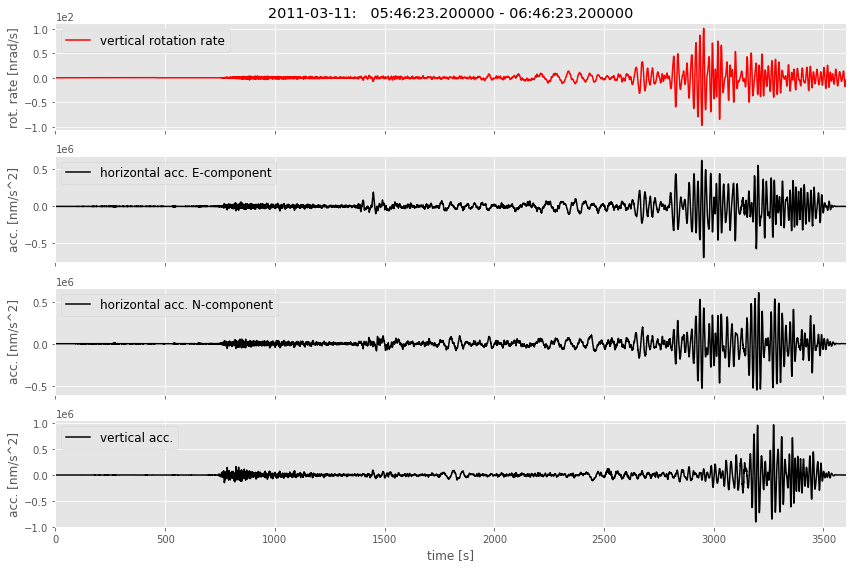

In [7]:
import matplotlib.pyplot as plt
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, sharex=True)

ax1.set_title(str(start.date) + ':   ' + str(start.time) + " - " + str(end.time))
ax1.plot(RLAS[0].times(), RLAS[0],'r',label='vertical rotation rate')
ax1.set_ylabel('rot. rate [nrad/s]')
ax2.plot(AC[0].times(),AC[0],'k',label='horizontal acc. E-component')
ax2.set_ylabel('acc. [nm/s^2]')
ax3.plot(AC[1].times(),AC[1],'k',label='horizontal acc. N-component')
ax3.set_ylabel('acc. [nm/s^2]')
ax4.plot(AC[2].times(),AC[2],'k',label='vertical acc.')
ax4.set_ylabel('acc. [nm/s^2]')
ax4.set_xlabel('time [s]')

for ax in [ax1,ax2,ax3,ax4]:
    ax.legend(loc=2, prop={"size":12})
    ax.yaxis.major.formatter.set_powerlimits((-1,2))
    ax.set_xlim(0,max(AC[0].times()))

fig.tight_layout()
plt.show()

### Resample, Filter and Rotate
Resample seismograms using **decimate** in order to reduce the size of the arrays (speeds up processing).
The seismograms are high-cut and low-cut filtered, depending on the frequency range of interest and the resolution of the instruments.

In [8]:
RLAS.decimate(factor=4)
AC.decimate(factor=4)
high_cut = 1.0
low_cut = 0.005

RLAS.filter('bandpass', freqmax=high_cut, freqmin=low_cut, corners=2, zerophase=True)
AC.filter('bandpass', freqmax=high_cut, freqmin=low_cut, corners=2, zerophase=True)

3 Trace(s) in Stream:
GR.WET..BHE | 2011-03-11T05:46:22.574999Z - 2011-03-11T06:46:25.574999Z | 5.0 Hz, 18016 samples
GR.WET..BHN | 2011-03-11T05:46:22.574999Z - 2011-03-11T06:46:25.574999Z | 5.0 Hz, 18016 samples
GR.WET..BHZ | 2011-03-11T05:46:22.574999Z - 2011-03-11T06:46:25.574999Z | 5.0 Hz, 18016 samples

In order to align the seismometer recordings with the event direction, we need to rotate the horizontal components<br>
of the acceleration to transverse and radial.<br>
<br>
We can determine the theoretical rotation/direction angle (= backazimuth) from station and event location using **gps2dist_azimuth**.<br>
This function also yields the epicentral distance and the azimuth angle.

In [9]:
from obspy.geodetics.base import gps2dist_azimuth

# event location from event info
source_latitude = event.origins[0].latitude
source_longitude = event.origins[0].longitude

# station location (Wettzell)
station_latitude = 49.144001
station_longitude = 12.8782

# theoretical backazimuth and distance
baz = gps2dist_azimuth(source_latitude, source_longitude, station_latitude, station_longitude)

print('Epicentral distance [m]: ', baz[0])
print('Theoretical azimuth [deg]: ', baz[1])
print('Theoretical backazimuth [deg]: ', baz[2])

Epicentral distance [m]:  9127350.828896653
Theoretical azimuth [deg]:  329.4079811585143
Theoretical backazimuth [deg]:  37.602787067079454


We now rotate the E-N component seismometer recordings to radial [0] and transverse [1] acceleration using the theoretical BAz.<br>

In a last step the normalized **transverse acceleration** is plotted together with <font color='red'>**vertical rotation rate**</font>.

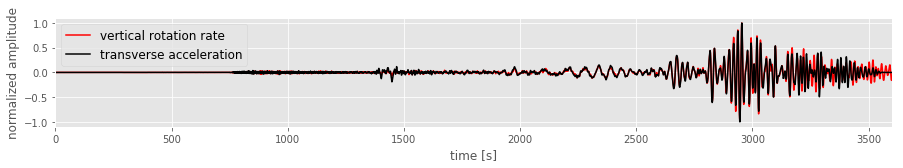

In [10]:
from obspy.signal.rotate import rotate_ne_rt
import numpy as np

# rotate
AC.rotate(method='NE->RT',back_azimuth=baz[2])
plt.figure(figsize=(15,2))

ax = plt.subplot(111)
ax.plot(RLAS[0].times(), RLAS[0].data/np.max(np.abs(RLAS[0].data)), 'r', label='vertical rotation rate')
ax.plot(AC[0].times(), AC[0].data/np.max(np.abs(AC[0].data)), 'k', label='transverse acceleration')
ax.legend(loc=2, prop={"size":12})
ax.set_xlabel('time [s]')
ax.set_ylabel('normalized amplitude')
ax.set_xlim(0,max(RLAS[0].times()))

plt.show()

**<big>Note: the vertical rotation rate and transverse acceleration are in phase!</big>**

### References
<ul>
    Beyreuther, M., R. Barsch, L. Krischer, T. Megies, Y. Behr and J. Wassermann (2010)<br>
    <a href=http://www.seismosoc.org/Publications/SRL/SRL_81/srl_81-3_es/>ObsPy: A Python Toolbox for Seismology</a> <br>
    SRL, 81(3), 530-533, doi: 10.1785/gssrl.81.3.530<br>
    <br>
    Krischer, L., T. Megies, R. Barsch, M. Beyreuther, T. Lecocq, C. Caudron, J. Wassermann (2015)<br>
    <a href=http://iopscience.iop.org/article/10.1088/1749-4699/8/1/014003/meta;jsessionid=429E7836F3590551E4FF9EE94853C476.c5.iopscience.cld.iop.org> 
    ObsPy: a bridge for seismology into the scientific Python ecosystem</a><br>
    Computational Science & Discovery, 8(1), 014003, doi: 10.1088/1749-4699/8/1/014003<br>
    <br>
    Megies, T., M. Beyreuther, R. Barsch, L. Krischer, J. Wassermann (2011)<br>
    <a href=http://www.annalsofgeophysics.eu/index.php/annals/article/view/4838>
    ObsPy – What can it do for data centers and observatories?</a> <br>
    Annals Of Geophysics, 54(1), 47-58, doi: 10.4401/ag-4838<br>
</ul>